In [ ]:
! pip install text_hammer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 38.3 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import numpy as np
import pandas as pd

import re
import text_hammer as th


import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

# Fliter Warnings
import warnings
warnings.filterwarnings('ignore')

# For pre processing
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

import keras

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  import sys


In [ ]:
df = pd.read_csv('drive/MyDrive/Finance news sentiment analysis/data/all-data.csv',names = ['sentiment', 'text'],  encoding='latin-1')
df.head()

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
df1 = df.copy()

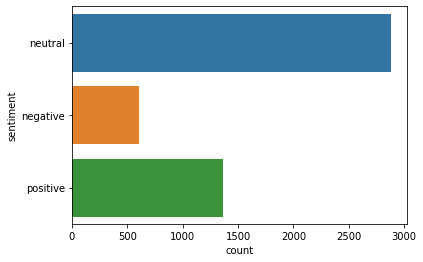

In [ ]:
sns.countplot(y = df['sentiment'])

In [ ]:
df.shape

(4846, 2)

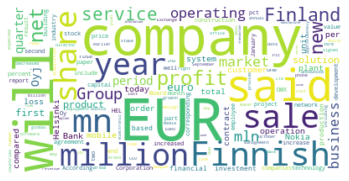

In [ ]:
# Creating a word cloud

text2 = " ".join(text for text in df.text)

# Creating word_cloud with text as argument in .generate() method

word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(text2)

# Display the generated Word Cloud

plt.imshow(word_cloud2, interpolation='bilinear')

plt.axis("off")

plt.show()

In [ ]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = th.cont_exp(x)
    x = th.remove_emails(x)
    x = th.remove_urls(x)
    x = th.remove_html_tags(x)
    x = th.remove_rt(x)
    x = th.remove_accented_chars(x)
    x = th.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

df1['text'] = df['text'].progress_apply(lambda x: get_clean(x))


  0%|          | 0/4846 [00:00<?, ?it/s]

In [ ]:
print("Text before cleaning : ", df['text'][0])
print("Text after cleaning  : ", df1['text'][0])

Text before cleaning :  According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Text after cleaning  :  according to gran the company has no plans to move all production to russia although that is where the company is growing


In [ ]:
# Converting the target varuable to ordinal values using a dictionary

dic = { 'negative' : 0,
       'neutral' :1,
       'positive' : 2}
df1['sentiment'] = df1['sentiment'].apply(lambda x: dic[x])
df1['sentiment'].value_counts()

1    2879
2    1363
0     604
Name: sentiment, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(df1['text'], df1['sentiment'], random_state = 42)

In [ ]:
print(f'Size of the xtrain is {xtrain.shape}')

Size of the xtrain is (3634,)


In [ ]:
# Over Sampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()

xtrain, ytrain = ros.fit_resample(np.array(df['text']).reshape(-1, 1), np.array(df['sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in xtrain], ytrain)), columns = ['text', 'sentiment']);

X = train_os['text'].values
y = train_os['sentiment'].values

xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)



In [ ]:
ytrain.shape

(7773,)

In [ ]:
# doing OHE and getting a ndarray as an output
ohe = OneHotEncoder()
ytrain = ohe.fit_transform(np.array(ytrain).reshape(-1, 1)).toarray()
yvalid = ohe.fit_transform(np.array(yvalid).reshape(-1, 1)).toarray()
ytest = ohe.fit_transform(np.array(ytest).reshape(-1, 1)).toarray()

In [ ]:
ytrain.shape

(7773, 3)

In [ ]:
# While running on colab we have to perform this often
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 8.4 MB/s 
     |████████████████████████████████| 596 kB 19.8 MB/s 
     |████████████████████████████████| 101 kB 5.9 MB/s 
     |████████████████████████████████| 6.6 MB 25.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Importing the bert model and bert tokenizer

from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# A example of autotokenizer outputs
tokenizer('my name is shivam')

{'input_ids': [101, 2026, 2171, 2003, 12535, 2213, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [ ]:
print("Max len of News",max([len(x.split()) for x in df1.text]))

Max len of News 52


In [ ]:
# As max len news is 52 so we can have a max len of 64
max_len = 64

In [ ]:
# Creating the tokens for xtrain and xtest

xtrain = tokenizer(text=xtrain.tolist(),
    add_special_tokens=True,
    max_length=64,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

xvalid = tokenizer(text=xvalid.tolist(),
    add_special_tokens=True,
    max_length=64,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

xtest = tokenizer(text=xtest.tolist(),
    add_special_tokens=True,
    max_length=64,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
xtrain['input_ids'].shape

TensorShape([7773, 64])

> Building the model architecture

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Input, Dense, Dropout
from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping
from keras.initializers import TruncatedNormal
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy,BinaryAccuracy
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model

In [ ]:
MAX_LEN = 64
def create_model(bert_model, max_len=MAX_LEN):

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = Dropout(0.15)(embeddings)
    output = Dense(128, activation = 'relu')(output)
    output = Dropout(0.15)(output)
    output = Dense(64, activation = 'relu')(output)
    output = tf.keras.layers.Dense(3, activation="softmax")(output)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    # Params
    opt = adam_v2.Adam(
    learning_rate=6e-06, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
    # opt = keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = keras.losses.CategoricalCrossentropy()
    accuracy = keras.metrics.CategoricalAccuracy()

    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

    

In [ ]:
model = create_model(bert, MAX_LEN)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 64,                                            

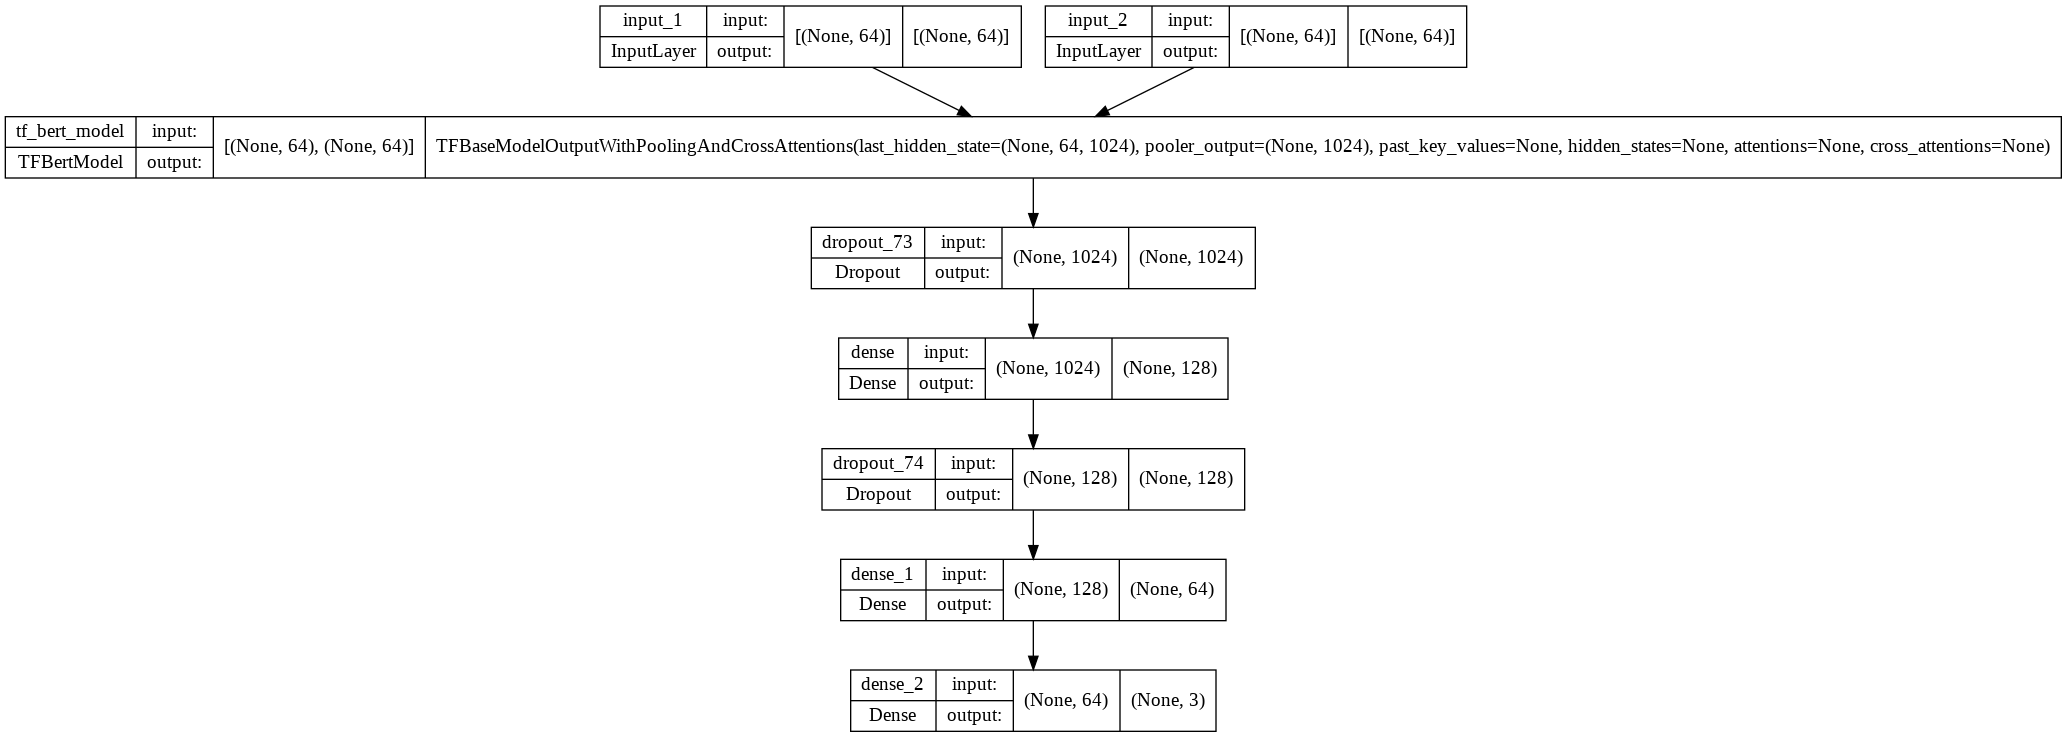

In [ ]:
plot_model(model, show_shapes = True)

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath=f'drive/MyDrive/Finance news sentiment analysis/model.{epoch:02d}-{val_loss:.2f}.h5'),
]

In [ ]:
history_bert = model.fit([xtrain['input_ids'],xtrain['attention_mask']], ytrain, 
                         validation_data=([xvalid['input_ids'],xvalid['attention_mask']], yvalid),
                         callbacks=my_callbacks
                         epochs=4, batch_size=32) #batch_size = 16

Epoch 1/4
243/243 [==============================] - 427s 1s/step - loss: 0.8788 - categorical_accuracy: 0.5800 - val_loss: 0.5123 - val_categorical_accuracy: 0.8241
Epoch 2/4
243/243 [==============================] - 340s 1s/step - loss: 0.4837 - categorical_accuracy: 0.8268 - val_loss: 0.3787 - val_categorical_accuracy: 0.8565
Epoch 3/4
243/243 [==============================] - 342s 1s/step - loss: 0.3754 - categorical_accuracy: 0.8679 - val_loss: 0.3358 - val_categorical_accuracy: 0.8715
Epoch 4/4
243/243 [==============================] - 340s 1s/step - loss: 0.3183 - categorical_accuracy: 0.8873 - val_loss: 0.3093 - val_categorical_accuracy: 0.8854


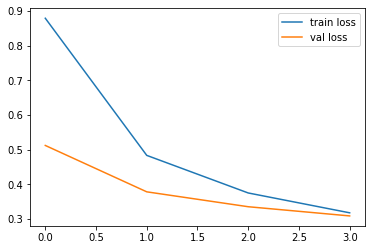

<Figure size 432x288 with 0 Axes>

In [ ]:
# plt.figure(figsize = (10,10))
plt.plot(history_bert.history['loss'], label='train loss')
plt.plot(history_bert.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('drive/MyDrive/Finance news sentiment analysis/LossVal_loss')

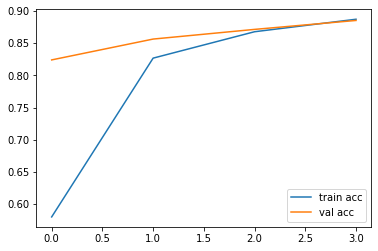

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the accuracy
plt.plot(history_bert.history['categorical_accuracy'], label='train acc')
plt.plot(history_bert.history['val_categorical_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('drive/MyDrive/Finance news sentiment analysis/AccVal_acc')

In [ ]:
result_bert = model.predict([xtest['input_ids'],xtest['attention_mask']])

In [ ]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

Text(0.5, 15.0, 'Predicted')

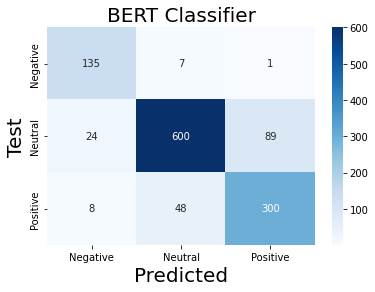

In [ ]:
labels = ['Negative', 'Neutral', 'Positive']


plt.plot()
sns.heatmap(confusion_matrix(ytest.argmax(1), y_pred_bert.argmax(1)), annot = True, fmt='g',cmap = 'Blues',
            xticklabels = labels, yticklabels = labels)

plt.title('BERT Classifier', fontsize=20)
plt.ylabel('Test', fontsize=20)
plt.xlabel('Predicted', fontsize=20)
plt.savefig('')

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(ytest,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.81      0.94      0.87       143
     Neutral       0.92      0.84      0.88       713
    Positive       0.77      0.84      0.80       356

   micro avg       0.85      0.85      0.85      1212
   macro avg       0.83      0.88      0.85      1212
weighted avg       0.86      0.85      0.86      1212
 samples avg       0.85      0.85      0.85      1212



In [ ]:
# saveing model as h5 file using keras_model
from tensorflow.keras.models import load_model

model.save('drive/MyDrive/Finance news sentiment analysis/bert_news.h5')

In [157]:
# from tensorflow.keras.models import load_model
# model=load_model('bert_news.h5')

In [ ]:
from keras.preprocessing.sequence import pad_sequences
def pred(x):
  text = get_clean(x)
  # text = pd.series(text)
  token = tokenizer(text,
    add_special_tokens=True,
    max_length=64,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    )
  
  # Padding the sequence as the max_len is 64
  input_id = pad_sequences( token['input_ids'] , maxlen = 64, padding = 'post',truncating='pre', value = 0 )
  attention_mask = pad_sequences( token['attention_mask'] , maxlen = 64, padding = 'post',truncating='pre', value = 0 )
  prediction = model.predict([input_id, attention_mask])
  
  pr = np.argmax(prediction)
  pre_prob = np.max(prediction)
  labels = ['Negative', 'Neutral', 'Positive']
  # print(f'The model has predicted {labels[pr]} Sentiment with the Probability of {pre_prob}')
  # Giving the mode' a threshold
  if pre_prob >= 0.78:
    print(f'The model has predicted "{labels[pr]}" Sentiment with the Probability of {pre_prob}%')
  else:
    print("Can't say the sentiment as the predicted sentiment is not up to mark.")
    print(f'The model has predicted "{labels[pr]}" Sentiment with the Probability of {pre_prob}%')
  

In [ ]:
text = str(input('Copy paste the news you like analyise the result : '))
pred(text)

Copy paste the news you like analyise the result : CLGT’s 1QFY23 sales and gross profit were in line. Higher than forecasted other expenses led to an EBITDA miss. The management said 1QFY23 was impacted by a slowdown in rural India and inflationary pressures. It remains cautiously optimistic of improving trends in coming quarters.  While we await the response of re-launches/launches and the strategy under the new CEO, the core issue of lack of sales growth (caused by high category penetration, especially when allied with the fact that CLGT has not shown any signs of regaining lost market share), will continue to delay rerating of the stock, given the little signs of a shift from its dependence on Oral Care. We maintain our Neutral rating.
The model has predicted "Negative" Sentiment with the Probability of 0.7855477929115295%


Neutral CLGT; target of Rs 1,586: Motilal Oswal

Motilal Oswal is bullish on Tata Motors recommended Neutral rating on the stock  in its research report dated July 28, 2022.
 BROKER RESEARCH JULY 29, 2022 / 11:35 P 


NSELIVE
Motilal Oswal's research report on CLGT.

CLGT’s 1QFY23 sales and gross profit were in line. Higher than forecasted other expenses led to an EBITDA miss. The management said 1QFY23 was impacted by a slowdown in rural India and inflationary pressures. It remains cautiously optimistic of improving trends in coming quarters.  While we await the response of re-launches/launches and the strategy under the new CEO, the core issue of lack of sales growth (caused by high category penetration, especially when allied with the fact that CLGT has not shown any signs of regaining lost market share), will continue to delay rerating of the stock, given the little signs of a shift from its dependence on Oral Care. We maintain our Neutral rating.